In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from src.ds import Dataset, collate_fn
from torch.utils.data import DataLoader
import time

Intentando acelerar el data loading...

In [3]:
train = pd.read_json('data/train.json')

In [4]:
ds = Dataset(
	train.filename.values, 
	(0, 1, 2),
	(2,1,0), 
	['September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August'], 
	train.label.values
)

In [5]:
# measure time to load data

results = []
num_batches = 100
# con 12 meses peta a partir de bs 16
for bs in [1, 2, 4, 8]: #, 16, 32, 64]:
	dl = DataLoader(ds, batch_size=bs, shuffle=True, num_workers=10, pin_memory=True, collate_fn=collate_fn)
	start = time.time()
	for i, batch in enumerate(dl):
		(s1, s2), y = batch
		s1, s2 = s1.cuda(), s2.cuda()
		# s1, s2 = s1.cuda(non_blocking=True), s2.cuda(non_blocking=True)
		if i == num_batches:
			break
	end = time.time()
	print(f'100 batches loaded in {end-start:.2f} seconds')
	results.append((bs, end-start))

100 batches loaded in 3.35 seconds
100 batches loaded in 3.54 seconds
100 batches loaded in 7.01 seconds
100 batches loaded in 15.52 seconds


In [6]:
import cupy as cp

class ExternalInputIterator(object):
    def __init__(self, chip_ids, batch_size):
        self.batch_size = batch_size
        self.chip_ids = chip_ids
        self.sensors = ['S1', 'S2']

    def __iter__(self):
        self.i = 0
        self.n = len(self.chip_ids)
        return self

    def __next__(self):
        batch1, batch2, labels = [], [], []
        for _ in range(self.batch_size):
            chip_id = self.chip_ids[self.i]
            x1 = cp.load(
                f'data/train_features_npy/{chip_id}_S1.npy')
            x2 = cp.load(
                f'data/train_features_npy/{chip_id}_S2.npy')
            label = cp.load(f'data/train_agbm_npy/{chip_id}.npy')
            # x1 = rearrange(x1, 'h w c l -> l h w c') # peta la pipeline
            # x2 = rearrange(x2, 'h w c l -> l h w c')
            label = label[...,None]
            batch1.append(x1)
            batch2.append(x2)
            labels.append(label)
            self.i = (self.i + 1) % self.n
        return (batch1, batch2, labels)

    def __len__(self):
        return self.data_set_len

    next = __next__

In [7]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types

train = pd.read_csv('data/train_chip_ids.csv')
batch_size = 4
eii = ExternalInputIterator(
	train.chip_id.values, 
	batch_size
)

x1, x2, labels = next(iter(eii))

In [17]:
batch_size = 4
pipe = Pipeline(batch_size=batch_size, num_threads=2, device_id=0)
seed = 1
trans = False
with pipe:
    x1, x2, labels = fn.external_source(source=eii, num_outputs=3, device="gpu", dtype=types.FLOAT)
    # if trans:
    #     x1 = fn.flip(x1, horizontal=fn.random.coin_flip(seed=seed), vertical=fn.random.coin_flip(seed=seed))
    #     x2 = fn.flip(x2, horizontal=fn.random.coin_flip(seed=seed), vertical=fn.random.coin_flip(seed=seed))
    #     labels = fn.flip(labels, horizontal=fn.random.coin_flip(seed=seed), vertical=fn.random.coin_flip(seed=seed))
    #     x1 = fn.rotate(x1, angle=90*fn.random.uniform(values=[0,1,2,3], seed=seed))
    #     x2 = fn.rotate(x2, angle=90*fn.random.uniform(values=[0,1,2,3], seed=seed))
    #     labels = fn.rotate(labels, angle=90*fn.random.uniform(values=[0,1,2,3], seed=seed))
    #     # axis = fn.random.uniform(values=[0,1], seed=seed)
    #     # x1 = fn.transpose(x1, perm=[0,1+axis,2-axis,3])
    pipe.set_outputs(x1, x2, labels)

pipe.build()

In [18]:
pipe_out = pipe.run()
pipe_out

(TensorListGPU(
     [[[[[0.42642784 0.60205966 0.5142437 ]
         [0.46515542 0.6599043  0.5625299 ]
         ...
         [0.29797798 0.5564118  0.42719486]
         [0.30800146 0.56191474 0.43495813]]
 
        [[0.44248462 0.63242173 0.53745323]
         [0.4735455  0.69412774 0.5838366 ]
         ...
         [0.31310946 0.5612534  0.4371814 ]
         [0.33922395 0.5804157  0.45981985]]
 
        ...
 
        [[0.36348388 0.5430358  0.4532599 ]
         [0.3672495  0.5442546  0.45575204]
         ...
         [0.3952591  0.5477305  0.47149482]
         [0.36543268 0.56297034 0.4642015 ]]
 
        [[0.38546023 0.59100145 0.48823082]
         [0.3808958  0.597639   0.4892674 ]
         ...
         [0.39770922 0.5592405  0.4784749 ]
         [0.39180785 0.556085   0.4739464 ]]]
 
 
       [[[0.39542863 0.64275837 0.51909345]
         [0.41169363 0.655473   0.53358334]
         ...
         [0.3334917  0.57787025 0.455681  ]
         [0.33702204 0.59604675 0.46653438]]
 
       

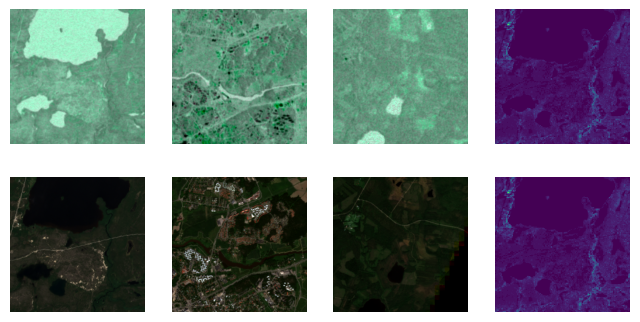

In [19]:
import matplotlib.pyplot as plt

s1s, s2s, labels = pipe_out
s1s, s2s, labels = s1s.as_cpu(), s2s.as_cpu(), labels.as_cpu()

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(2, 4, 1)
ax.imshow(s1s.at(0)[0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 2)
ax.imshow(s1s.at(1)[1])
ax.axis('off')
ax = fig.add_subplot(2, 4, 3)
ax.imshow(s1s.at(2)[2])
ax.axis('off')
ax = fig.add_subplot(2, 4, 4)
ax.imshow(labels.at(0))
ax.axis('off')
ax = fig.add_subplot(2, 4, 5)
ax.imshow(s2s.at(0)[10])
ax.axis('off')
ax = fig.add_subplot(2, 4, 6)
ax.imshow(s2s.at(1)[10])
ax.axis('off')
ax = fig.add_subplot(2, 4, 7)
ax.imshow(s2s.at(2)[10])
ax.axis('off')
ax = fig.add_subplot(2, 4, 8)
ax.imshow(labels.at(0))
ax.axis('off')
plt.show()

In [38]:
from nvidia.dali.plugin.pytorch import DALIGenericIterator

results = []
num_batches = 100
for bs in [1, 2, 4, 8, 16, 32]:#, 64]:
	eii = ExternalInputIterator(
		train.chip_id.values, 
		batch_size=bs
	)
	pipe = Pipeline(batch_size=bs, num_threads=10, device_id=0)
	with pipe:
		x1, x2, labels = fn.external_source(source=eii, num_outputs=3, device="gpu", dtype=types.FLOAT)
		pipe.set_outputs(x1, x2, labels)
	pipe.build()
	pii = DALIGenericIterator([pipe], ['s1s', 's2s', 'labels'])
	start = time.time()
	for i, data in enumerate(pii):
		batch_data = data[0]
		s1s, s2s, labels = batch_data["s1s"], batch_data["s2s"], batch_data["labels"]
		if i == num_batches:
			print(s1s.shape, s1s.device)
			break
	end = time.time()
	print(f'100 batches loaded in {end-start:.2f} seconds')
	results.append((bs, end-start))

torch.Size([1, 12, 256, 256, 3]) cuda:0
100 batches loaded in 1.24 seconds
torch.Size([2, 12, 256, 256, 3]) cuda:0
100 batches loaded in 1.78 seconds
torch.Size([4, 12, 256, 256, 3]) cuda:0
100 batches loaded in 3.41 seconds
torch.Size([8, 12, 256, 256, 3]) cuda:0
100 batches loaded in 7.05 seconds
torch.Size([16, 12, 256, 256, 3]) cuda:0
100 batches loaded in 13.73 seconds
torch.Size([32, 12, 256, 256, 3]) cuda:0
100 batches loaded in 27.37 seconds


Inceríble speedup!